### Analysing the consequences of amber codon suppression

This analysis aims to analyse the consequences of [amber codon suppression](https://en.wikipedia.org/wiki/Expanded_genetic_code). Amber codon suppression is a synthetic biology approach where an engineered tRNA (suppressor tRNA) can recognise the amber codon (UAG) and promote stop-codon readthrough. This approach is useful for incorporating non-canonical amino acids into specific proteins for various downstream applications.

We are interested in the identifying the potential consequences of amber codon suppression, as stop-codon readthrough could occur on cellular proteins, resulting in C-terminal extensions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We will download the protein-coding sequences from GENCODE.

In [2]:
! wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/gencode.v45.pc_transcripts.fa.gz -O ref

--2024-04-03 14:05:10--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_45/gencode.v45.pc_transcripts.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47890586 (46M) [application/x-gzip]
Saving to: ‘gencode.v45.pc_transcripts.fa.gz’

100%[======================================>] 47,890,586   214KB/s   in 3m 45s 

2024-04-03 14:08:57 (208 KB/s) - ‘gencode.v45.pc_transcripts.fa.gz’ saved [47890586/47890586]



We will reuse our previously published dictionaries for translating codons to amino acids.

In [2]:
# https://github.com/Gardner-BinfLab/TIsigner_paper_2019/blob/master/feature_analysis_and_optimisation/Benchmarking/libs/data.py

#DEFAULT SETTINGS AND CONSTANTS
STOP_CODONS = ['TAG', 'TAA', 'TGA']

AA_TO_CODON = {'A' : ['GCT', 'GCC', 'GCA', 'GCG'],
               'C' : ['TGT', 'TGC'],
               'D' : ['GAT', 'GAC'],
               'E' : ['GAA', 'GAG'],
               'F' : ['TTT', 'TTC'],
               'G' : ['GGT', 'GGC', 'GGA', 'GGG'],
               'H' : ['CAT', 'CAC'],
               'I' : ['ATT', 'ATC', 'ATA'],
               'K' : ['AAG', 'AAA'],
               'L' : ['TTA', 'TTG', 'CTT', 'CTC', 'CTG', 'CTA'],
               'M' : ['ATG'],
               'N' : ['AAT', 'AAC'],
               'P' : ['CCT', 'CCC', 'CCA', 'CCG'],
               'Q' : ['CAA', 'CAG'],
               'R' : ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
               'S' : ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
               'T' : ['ACT', 'ACC', 'ACA', 'ACG'],
               'V' : ['GTT', 'GTC', 'GTA', 'GTG'],
               'W' : ['TGG'],
               'Y' : ['TAT', 'TAC']}


CODON_TO_AA = {'TTT' : 'F', 'TCT' : 'S', 'TAT' : 'Y', 'TGT' : 'C',
               'TTC' : 'F', 'TCC' : 'S', 'TAC' : 'Y', 'TGC' : 'C',
               'TTA' : 'L', 'TCA' : 'S', 'TTG' : 'L', 'TCG' : 'S',
               'TGG' : 'W', 'CTT' : 'L', 'CCT' : 'P', 'CAT' : 'H',
               'CGT' : 'R', 'CTC' : 'L', 'CCC' : 'P', 'CAC' : 'H',
               'CGC' : 'R', 'CTA' : 'L', 'CCA' : 'P', 'CAA' : 'Q',
               'CGA' : 'R', 'CTG' : 'L', 'CCG' : 'P', 'CAG' : 'Q',
               'CGG' : 'R', 'ATT' : 'I', 'ACT' : 'T', 'AAT' : 'N',
               'AGT' : 'S', 'ATC' : 'I', 'ACC' : 'T', 'AAC' : 'N',
               'AGC' : 'S', 'ATA' : 'I', 'ACA' : 'T', 'AAA' : 'K',
               'AGA' : 'R', 'ATG' : 'M', 'ACG' : 'T', 'AAG' : 'K',
               'AGG' : 'R', 'GTT' : 'V', 'GCT' : 'A', 'GAT' : 'D',
               'GGT' : 'G', 'GTC' : 'V', 'GCC' : 'A', 'GAC' : 'D',
               'GGC' : 'G', 'GTA' : 'V', 'GCA' : 'A', 'GAA' : 'E',
               'GGA' : 'G', 'GTG' : 'V', 'GCG' : 'A', 'GAG' : 'E',
               'GGG' : 'G',
              'TAG':'*', 'TAA':'*', 'TGA':'*'}

We reuse fasta_to_dataframe and create a function called gencode_parser to process the fasta headers with the start/stop codon positions.

In [3]:
def fasta_to_dataframe(seq):
    fasta_df = pd.read_csv(seq, sep='>', lineterminator='>', header=None)
    df = fasta_df[0].str.split('\n', n=1, expand=True)
    df[1] = df[1].replace('\n','', regex=True)
    df = df[df[1] != '']
    df = df.dropna()
    df.columns = ['tid','seq']
    return df

def gencode_parser(seq):
    df = fasta_to_dataframe(seq)
    df['CDS'] = df.tid.str.split('|').apply(lambda x: [i for i in x if i.startswith('CDS:')]).apply(pd.Series)
    df['tid'] = df.tid.str.split('|').apply(lambda x: x[0])
    df[['CDS_start','CDS_end']] = df.CDS.str.replace('CDS:','').str.split('-', expand=True)
    df.dropna(inplace=True)
    df['CDS_start'] = df.CDS_start.astype('int')
    df['CDS_start'] = df.CDS_start - 1
    df['CDS_end'] = df.CDS_end.astype('int')
    df = df[(df.CDS_end-df.CDS_start)%3==0]
#     df['CDS_range'] = df[['CDS_start','CDS_end']].values.tolist()
    df = df.drop('CDS', axis=1).reset_index(drop=True)
    return df

Using annotated start/stop codon positions, we can extract the stop codons.

In [4]:
df = gencode_parser('../ref/gencode.v45.pc_transcripts.fa.gz')
df['CDS'] = df[['seq','CDS_start','CDS_end']].values.tolist()
df['stop_codon'] = df.CDS.apply(lambda x: x[0][x[1]:x[2]]).apply(lambda x: x[-3:])#.value_counts()

We can specifically take the subset transcripts with an amber codon.

In [5]:
amber = df[df.stop_codon=='TAG'] # transcripts with amber codons and 3'UTRs

# will deal with those without 3'UTRs later
amber_3utr = amber[amber.CDS_end!=amber.seq.apply(lambda x: len(x))].copy()

We will use list comprehension to split 3'UTR sequences by triplets and translate them into amino acids. The purpose is to find C-terminal extensions with downstream stop codons.

In [6]:
amber_3utr['codons'] = amber_3utr.CDS.apply(lambda x: x[0][x[1]:])
amber_3utr['codons'] = amber_3utr.codons.apply(lambda x: [x[i:i+3] for i in range(0, len(x), 3)])

amber_3utr['aa'] = amber_3utr.codons.apply(lambda x: x[:-1]).apply(lambda x: [CODON_TO_AA[i] for i in x])
amber_3utr['aa_seq'] = amber_3utr.aa.apply(lambda x: ''.join(x))
amber_3utr['aa_seq_split'] = amber_3utr['aa_seq'].str.split('*')

We will add lysine "K" to make create the C-terminal extended sequences.

In [7]:
amber_3utr['aa_seq'] = amber_3utr['aa_seq_split'].apply(lambda x: x[0] + 'K' + x[1])

This is a sanity check showing that most of the first codons are ATGs.

In [8]:
amber_3utr['codons'].apply(lambda x: x[0]).value_counts()

codons
ATG    16500
GTG       51
CTG       34
GAG       30
GGA       27
       ...  
TTA        3
ACG        3
CGA        2
TGT        1
TCG        1
Name: count, Length: 61, dtype: int64

There are 1169 sequences have no annotated 5'UTRs.

In [9]:
amber_3utr[amber_3utr.CDS_start==0].shape

(1169, 10)

We will get the lengths of the C-terminal extended sequences and visualise them using a boxplot.

The longest length of the C-terminal extended sequence is 652 amino acids.

In [10]:
amber_3utr['aa_seq_split'].apply(lambda x: len(x[1])).value_counts()

aa_seq_split
1       652
0       631
2       624
4       573
3       533
       ... 
578       1
388       1
1758      1
233       1
221       1
Name: count, Length: 327, dtype: int64

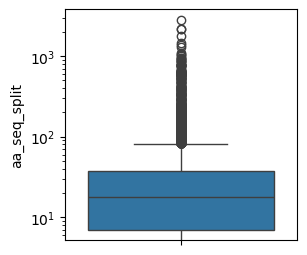

In [11]:
plt.figure(figsize=(3,3))
sns.boxplot(amber_3utr['aa_seq_split'].apply(lambda x: len(x[1])))
plt.yscale('log')

A total of 775 C-terminal extended sequences are greater than 100 amino acids.

In [12]:
amber_3utr[amber_3utr['aa_seq_split'].apply(lambda x: len(x[1]))>100].shape

(775, 10)

Here is the first example where "ILYNCEINLR" is the C-terminal extended sequence.

In [14]:
amber_3utr['aa_seq_split'].iloc[0]

['MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF',
 'ILYNCEINLR',
 '',
 'HKI',
 '',
 'SW',
 'VI',
 '',
 'SS',
 'KLCPPFPYNLVIV',
 'ELPHTLPQFIFQQLVCYILEYRYKVIMLSKYSFANS',
 'NKERHKYISICVHLFLPV',
 'P',
 'V',
 '',
 'KKGEKI',
 'PSL',
 'I',
 'KKIYLVHFVKNIKKELSHLNLKNICLVVRRYMSTFKRLKNKRLPL',
 'VYTSPPTTITTQNP',
 'GHYQE',
 'VEE',
 'VCQCEMCLLGPRRLWYNCS',
 'AVERI',
 'RDPGSHHVGTKYITWIHLCHFPWLMFKSTGFKVKNKELDSTLLTLINHDFGHIT',
 'LS',
 'ALVSTFINRRLYLLCMVIMKENDKIDINQIAHFETY',
 'A',
 'INIRYY',
 'NPIY',
 'QSQKFQTLLFPNILVKYDTSQS',
 'QMLIWDTVLVSGSVYICVQVCTHILPPYHPRKA',
 '',
 'KFKIEGKYKLKKKNLNK',
 'F',
 'QISSLSRENH',
 'ARIKLNTKYSKKKGI',
 'FVKM',
 'LELIDKESQMIRGSKLCLS',
 'EK',
 'NRKFISRLKTHNKSSK',
 '',
 '',
 'QYLKSVQGGKAY',
 'CDGGIIG',